# Segmentation of Streaming Time Series and Large Data Archives
The regular ClaSP algorithm is designed to segment medium-sized to large batch time series data. Many applications produce, however, an ongoing stream of observations or very large collections of sensor data. For this use case, we published <a href="https://doi.org/10.14778/3659437.3659450" target="_blank">ClaSS (Classification Score Stream)</a>, an optimized online implementation of the ClaSP algorithm for streaming time series. In this notebook, we explain how to use it.   

In [77]:
import numpy as np

from claspy.data_loader import load_has_dataset
from claspy.streaming.segmentation import StreamingClaSPSegmentation
from claspy.tests.evaluation import covering


In claspy, we provide access to the <a href="https://github.com/patrickzib/human_activity_segmentation_challenge" target="_blank">"Human Activity Segmentation Challenge"</a> benchmark. It consists of 250 multivariate TS with 1-15 segments. Each TS captures smartphone sensor data from 1 of 15 students performing everyday motion sequences. We choose a long time series as an example for our simulation of streaming time series data.  

In [78]:
df = load_has_dataset()
dataset, window_size, true_cps, labels, time_series = df.iloc[0,:]

# Streaming Time Series Segmentation
In streaming time series, each observation arrives in real-time, e.g. from incoming sensor data, and needs to be immediately processed with low latency to keep up with the throughput. For segmentation specifically, this means that we update a sliding window, e.g. last 3k data points, that gets partitioned in real-time. Streaming ClaSP efficiently updates its segmentation for every sliding window update reusing prior computations and provides access to the last detected change point. By default, this offset is 0 (no change) and increases to an index that splits the sliding window into two partitions, if a change is detected.

/Users/ermshaua/Documents/Git/public/claspy/claspy/validation.py:74: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12.0)


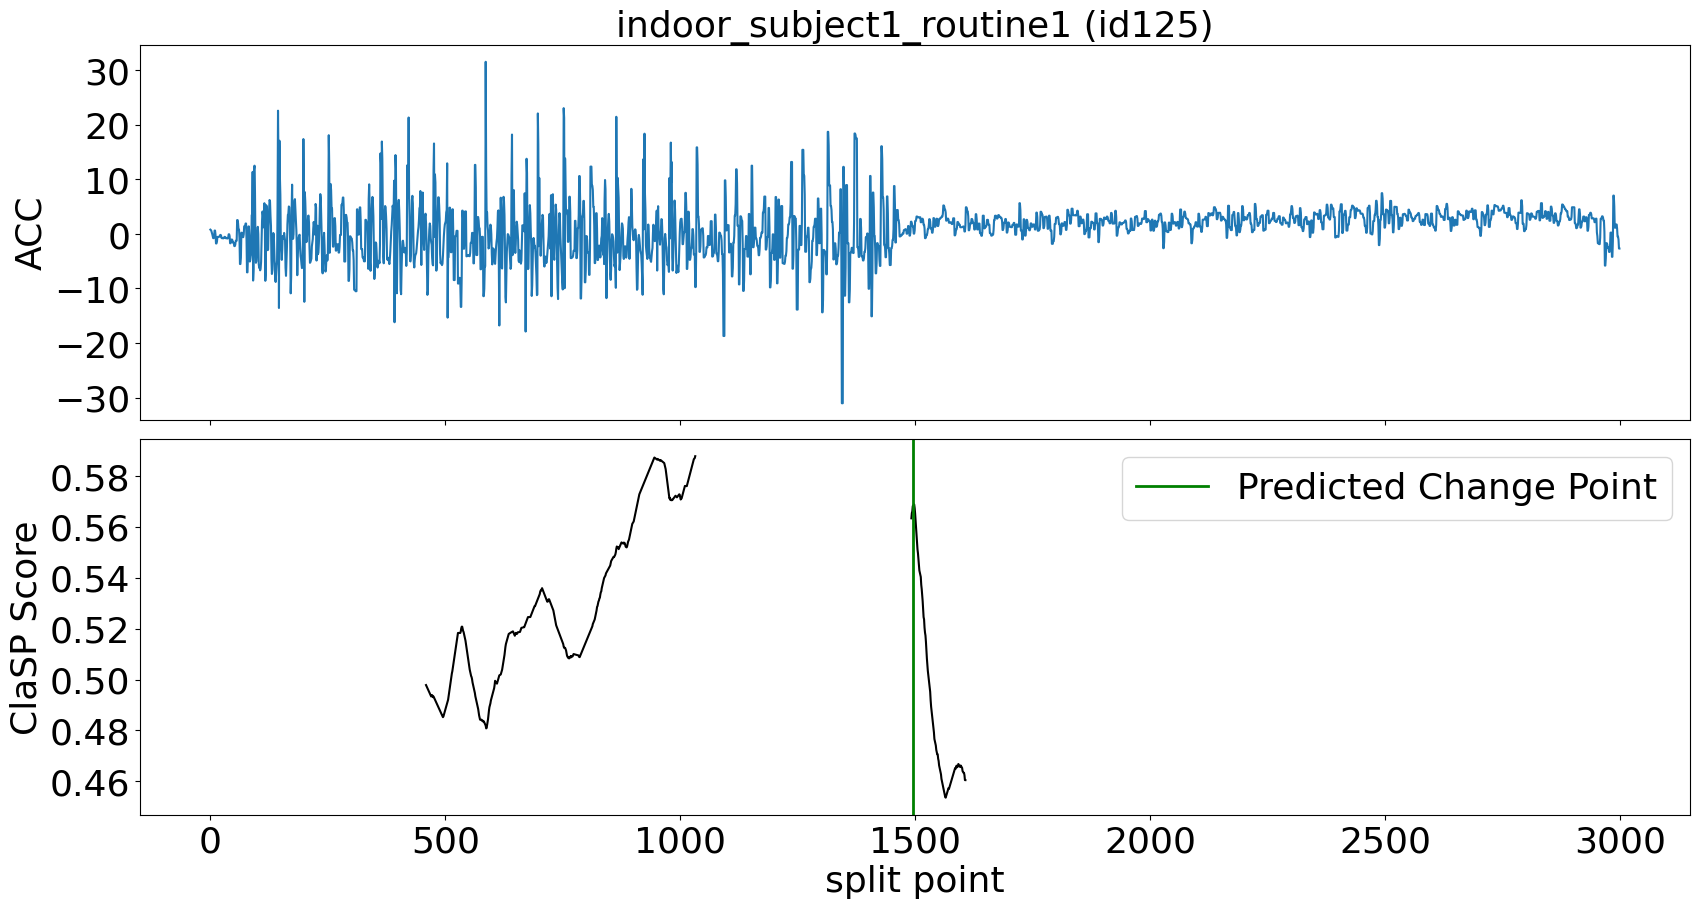

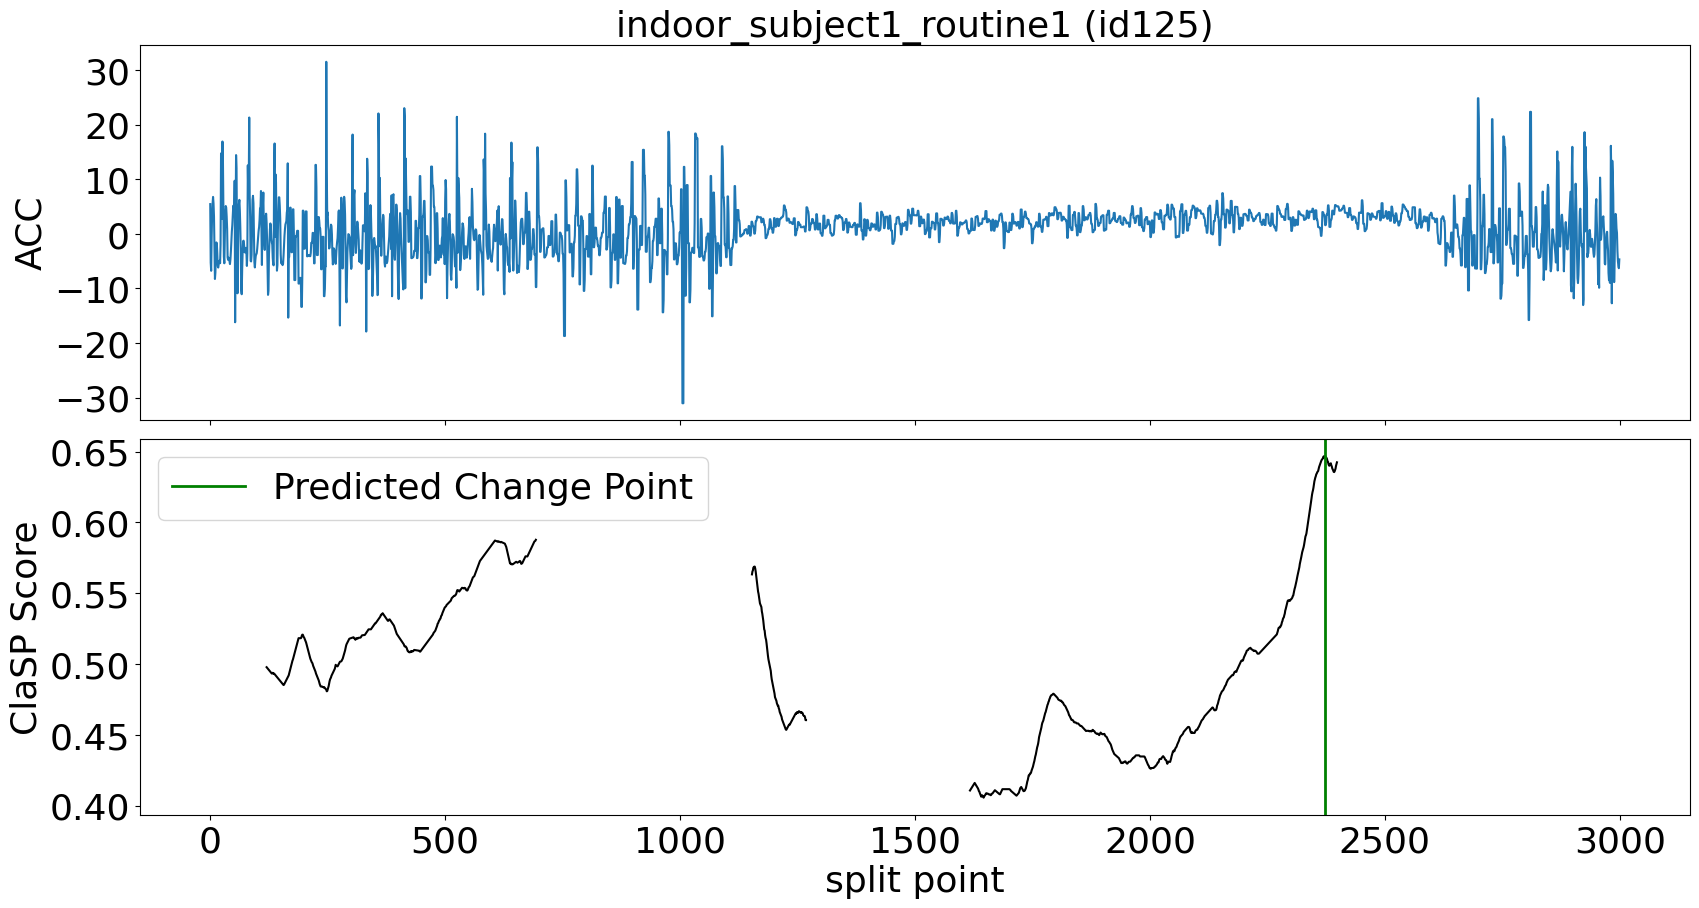

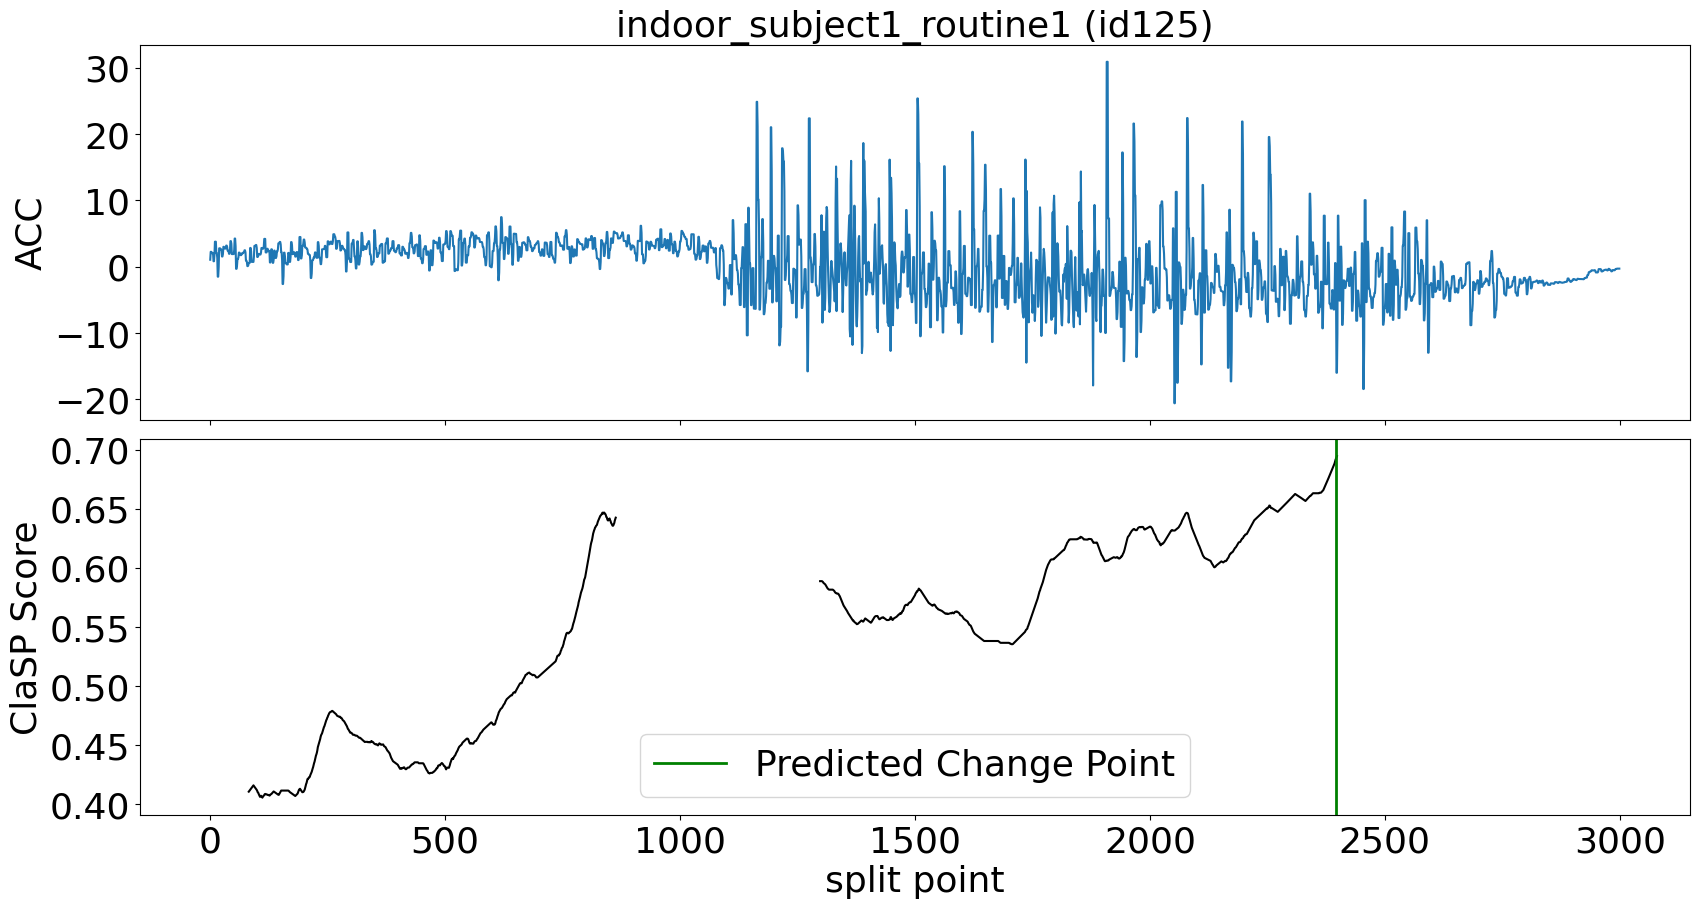

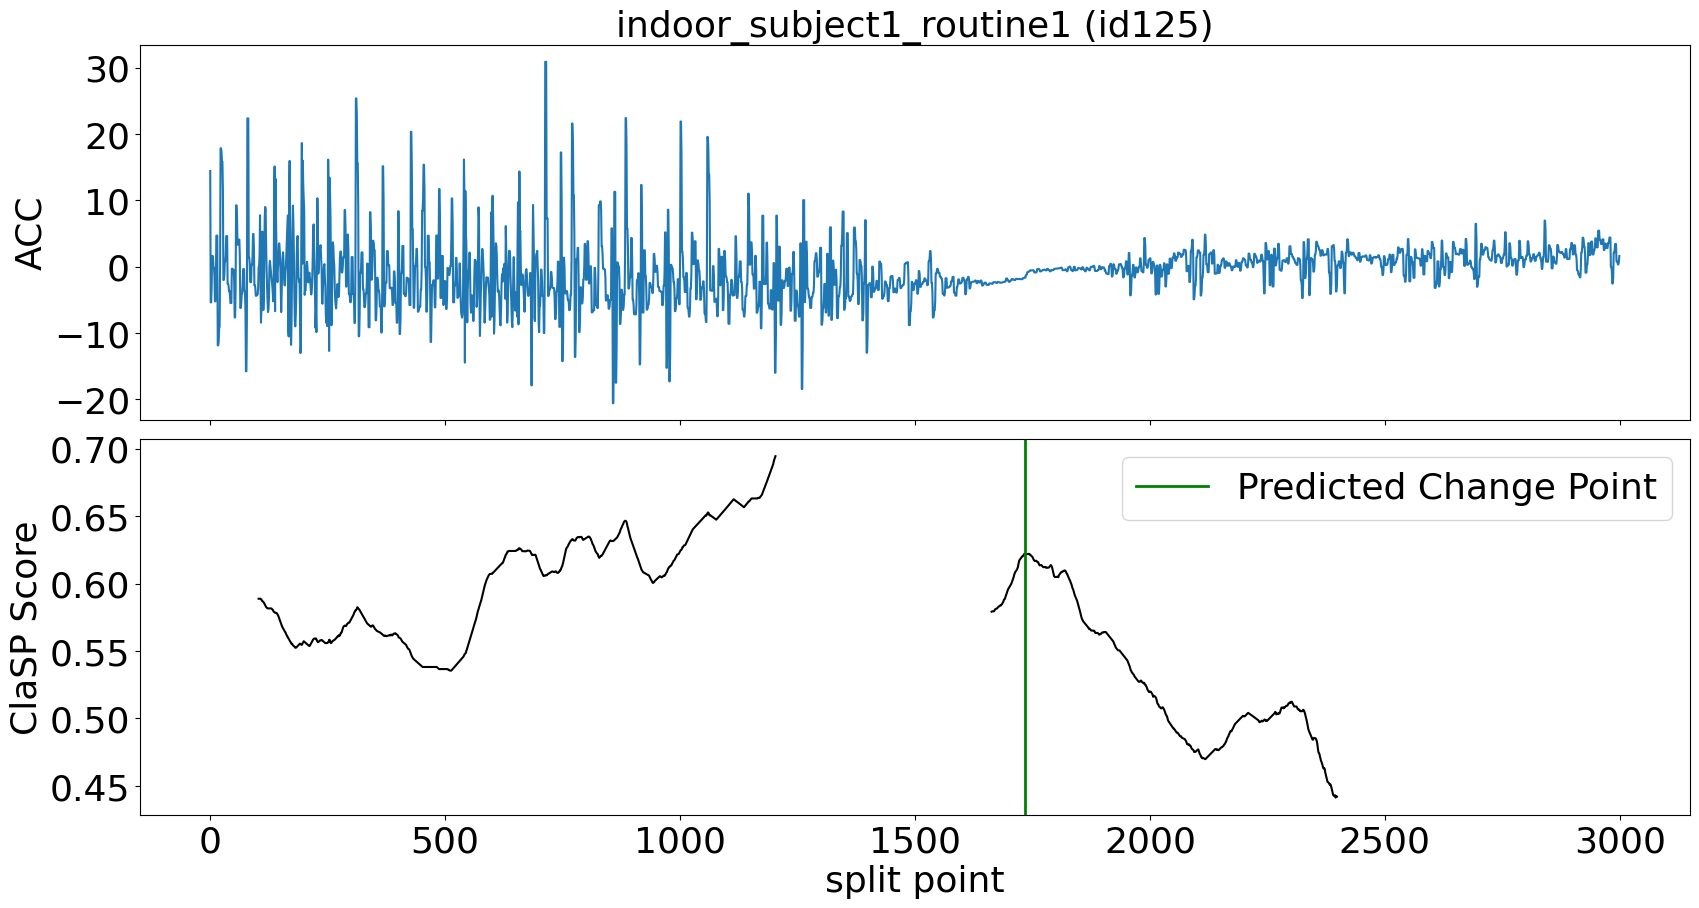

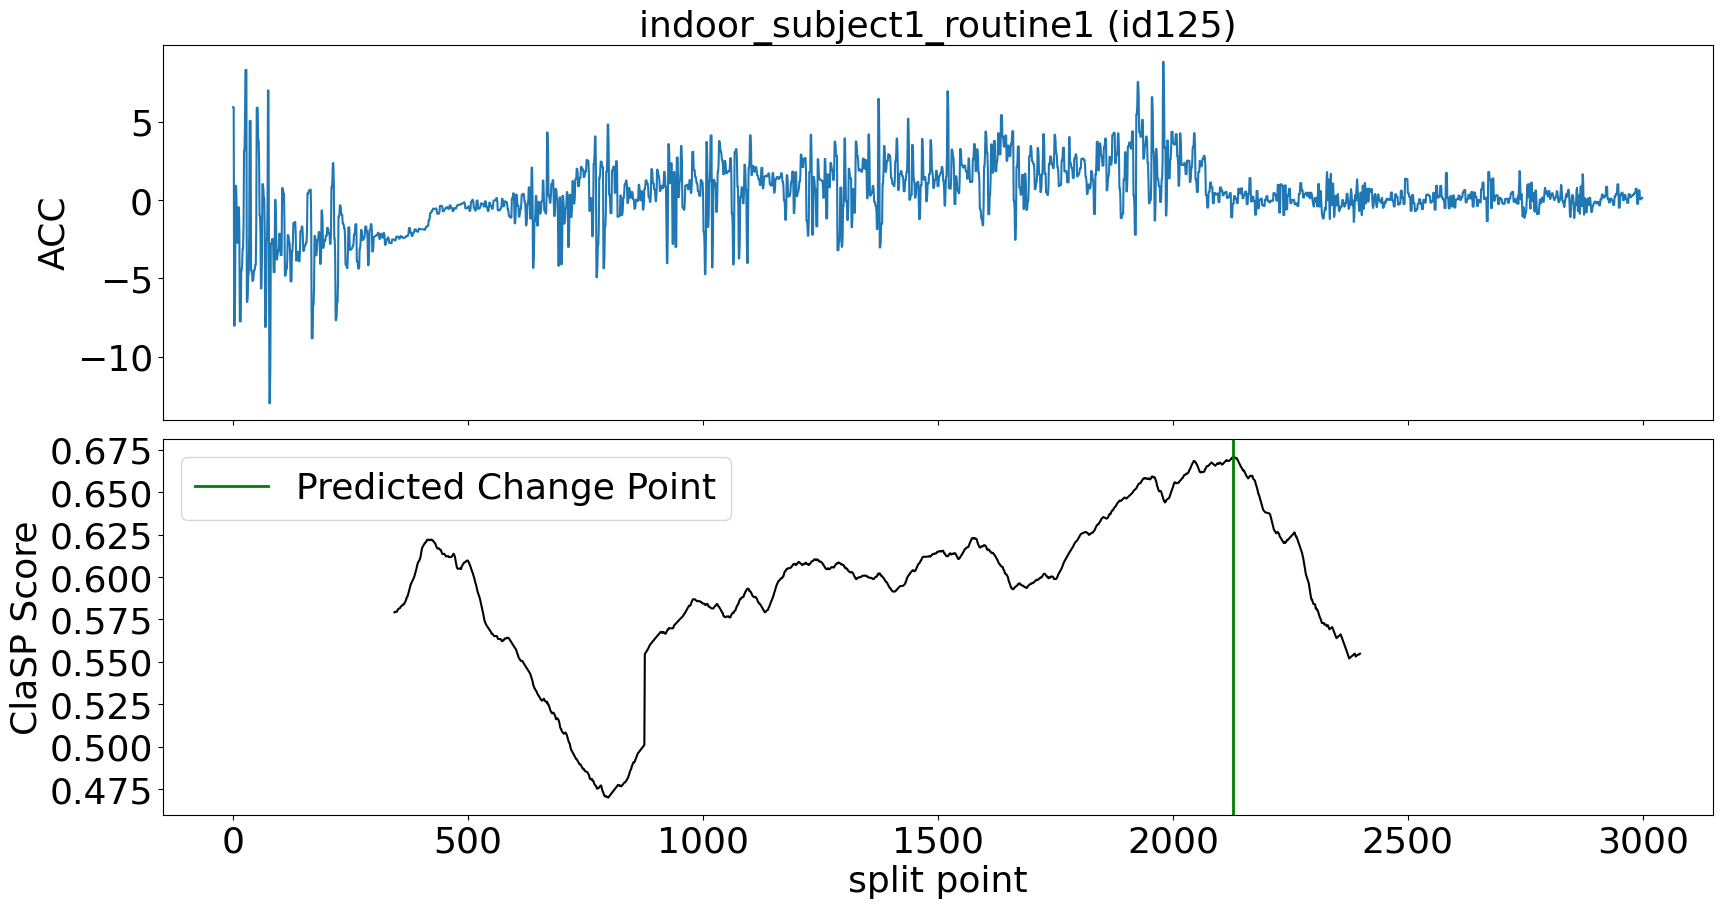

In [79]:
clasp = StreamingClaSPSegmentation(n_timepoints=3000)
last_cp = 0

for idx, value in enumerate(time_series[:,0]):
    # adjust shift in sliding window
    last_cp = max(0, last_cp-1)
    clasp.update(value)

    if idx >= clasp.n_warmup and clasp.predict() != last_cp:
        clasp.plot(
            heading=dataset,
            stream_name="ACC",
        )
        
        last_cp = clasp.predict()

In this example, we initialize the streaming ClaSP with a sliding window of `n_timepoints=3000` data points. Then we update the model with incoming time series observations and plot the sliding window segmentation once a new change gets detected in the stream. Hint: ClaSP needs an initial warmup phase to learn internal parameters. Thereafter, we can use `clasp.predict()` to report the last detected change point. This loop can run indefinitely to alert the user or to manage the incoming data. More detailed information is available in the <a href="https://doi.org/10.14778/3659437.3659450" target="_blank">publication</a>. 

# Segmentation of Large Data Archives
Technically, we can use the regular ClaSP to segment large time series data. However, at a certain size this becomes impractical, as it has quadratic runtime complexity regarding the number of observations. Therefore, we recommend using streaming ClaSP for very large time series, e.g. hundreds of thousands of data points or more. Its application is similiar to the streaming case and much faster than the regular ClaSP. Each update has linear runtime complexity regarding the sliding window size.  

In [80]:
clasp = StreamingClaSPSegmentation(n_timepoints=3000, log_cps=True)

for value in time_series[:,0]: 
    clasp.update(value)
    
clasp.change_points

[1125, 1590, 2805, 4365, 4898, 6611]

In the above example, we setup the streaming ClaSP to log all predicted change points with `log_cps=True` and update its sliding window with all available data points from the time series. Thereafter, we simply access all found CPs using `clasp.change_points`, e.g. to process the data or compute benchmark results.

In [81]:
print(f"Covering Score: {np.round(covering({0: true_cps}, clasp.change_points, time_series.shape[0]), 3)}")

Covering Score: 0.818


# Streaming ClaSP Configuration and Hyperparameter Tuning
Besides the streaming API and optimizations, the actual ClaSP segmentation result is very similar to the one from the batch implementation. It shares most parameters that behave in the same way. Therefore, we refer the interested reader to our <a href="https://github.com/ermshaua/claspy/blob/main/claspy/notebooks/clasp_configuration.ipynb">configuration notebook</a> for troubleshooting and further reading on the topic. 